Процесс подбора модели ARIMA в Питоне достаточно трудоёмок, поэтому вы не сможете вручную подобрать модель для каждого из рядов в выбранных ячейках. Чтобы облегчить ручной перебор, вам предстоит кластеризовать временные ряды и подобрать гиперпараметры модели ARIMA только один раз для всех рядов каждого кластера.

Результатом этой недели будут построенные с помощью ARIMA почасовые прогнозы количества поездок для всех географических зон Нью-Йорка. Модель, которую мы строим, должна делать почасовые прогнозы для всех выбранных непустых ячеек на 6 часов вперёд. Качество модели мы будем оценивать с помощью среднего абсолютного отклонения от истинного количества поездок в июне:

$$Q_{june} = {1 \over R * 715 * 6} +\sum_{r=1}^{R} \sum_{2016.05.31\ 23:00}^{2016.06.30\ 17:00}\sum_{i=1}^{6} |\hat{y}_{T|T+i} - y^r_{T+i}|$$

R — количество прогнозируемых рядов, 715 — количество перебираемых концов истории.

Построенные прогнозы вам предстоит загрузить на kaggle. К сожалению, в формате kaggle сложно организовать конкурс по прогнозированию временных рядов в традиционном виде, с отложенным тестом и пересчётом лидерборда, поскольку прогнозы необходимо строить со скользящим концом истории. Но цель использования kaggle в этом проекте — не победа в конкурсе; вы всегда можете загрузить истинные данные за июнь и получить первое место. Цель в том, чтобы посмотреть, какие модели, решения и признаки использовали ваши коллеги, и понять, какие из них стоит попробовать и вам.

In [25]:
%matplotlib inline

import warnings
import pickle
import sys
import os

import pandas as pd
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import  LinearRegression
from numpy.linalg.linalg import LinAlgError
from sklearn.decomposition import PCA
from datetime import datetime
from itertools import product
from pylab import rcParams
from scipy import stats
from tqdm import tqdm 

import statsmodels.tsa.api as tsa

from matplotlib import pyplot as plt
from statsmodels import api as sm

sys.setrecursionlimit(10000)
rcParams['figure.figsize'] = 15, 8
warnings.filterwarnings('ignore')
PATH_TO_DATA = '../data'

#### 1. Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!

In [3]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train.csv'), index_col=0, parse_dates=[0])

print(train_df.shape)
train_df.head()

(2904, 102)


,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2016-01-01 00:00:00,80.0,144.0,50.0,77.0,319.0,402.0,531.0,617.0,846.0,267.0,...,12.0,0.0,2.0,44.0,5.0,41.0,4.0,70.0,7.0,66.0
2016-01-01 01:00:00,91.0,211.0,49.0,134.0,404.0,420.0,370.0,453.0,594.0,224.0,...,29.0,0.0,5.0,2.0,2.0,4.0,0.0,47.0,1.0,29.0
2016-01-01 02:00:00,90.0,146.0,23.0,110.0,393.0,425.0,313.0,366.0,377.0,138.0,...,47.0,0.0,3.0,0.0,4.0,0.0,0.0,69.0,1.0,14.0
2016-01-01 03:00:00,32.0,87.0,16.0,62.0,252.0,399.0,324.0,309.0,327.0,166.0,...,46.0,0.0,2.0,4.0,5.0,1.0,0.0,21.0,0.0,9.0
2016-01-01 04:00:00,24.0,43.0,10.0,53.0,145.0,254.0,264.0,333.0,318.0,145.0,...,43.0,0.0,0.0,1.0,1.0,0.0,0.0,26.0,1.0,6.0


#### 2. Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.

In [219]:
df = (train_df - train_df.mean()) / train_df.std()
df.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2016-01-01 00:00:00,0.534241,0.178268,-0.565290,0.271008,1.423365,0.941171,1.327459,1.324730,1.906584,1.834661,...,1.550964,-0.883553,-0.571816,-1.047599,-1.251690,-0.786630,-0.681784,-0.821134,-0.855567,0.031375
2016-01-01 01:00:00,0.823251,1.005466,-0.582498,1.673565,2.292532,1.069110,0.407537,0.529737,0.846772,1.255014,...,5.252046,-0.883553,-0.069227,-1.325488,-1.275612,-1.423584,-1.171799,-1.125064,-1.089196,-0.930987
2016-01-01 02:00:00,0.796978,0.202960,-1.029900,1.083015,2.180052,1.104649,0.081851,0.108003,-0.065844,0.095721,...,9.170839,-0.883553,-0.404286,-1.338721,-1.259664,-1.492444,-1.171799,-0.834348,-1.089196,-1.321133
2016-01-01 03:00:00,-0.726896,-0.525467,-1.150354,-0.098086,0.738257,0.919848,0.144702,-0.168306,-0.276125,0.473165,...,8.953128,-0.883553,-0.571816,-1.312255,-1.251690,-1.475229,-1.171799,-1.468637,-1.128134,-1.451182
2016-01-01 04:00:00,-0.937086,-1.068702,-1.253601,-0.319543,-0.355871,-0.110772,-0.198126,-0.051966,-0.313975,0.190082,...,8.299996,-0.883553,-0.906875,-1.332105,-1.283586,-1.492444,-1.171799,-1.402566,-1.089196,-1.529211


#### 3. Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.

In [5]:
%%time
pca = PCA(n_components=2).fit(df.T.values)
result = pca.transform(df.T.values)

Wall time: 1.52 s


In [6]:
x = result[:, :-1].flatten()
y = result[:, -1:].flatten()

In [7]:
%%time
ac = AgglomerativeClustering(n_clusters=4)
clusters = ac.fit_predict(df.T.values)

Wall time: 409 ms


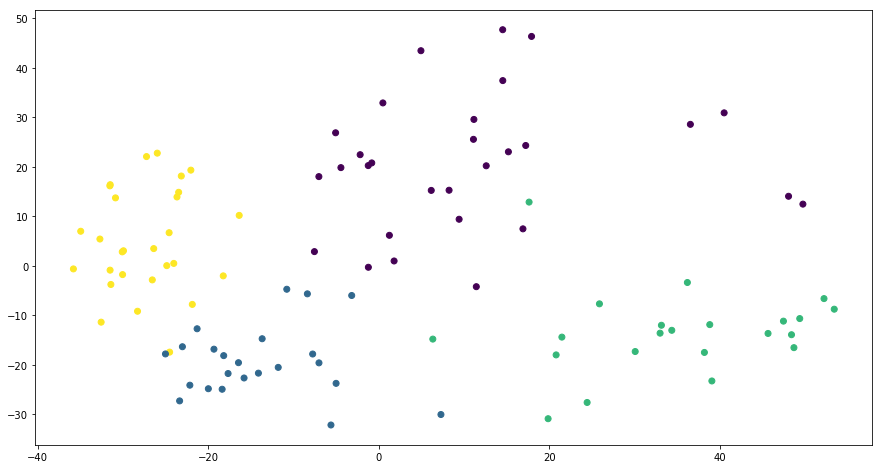

In [8]:
_ = plt.scatter(x, y, c=clusters)

#### 4. В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).

In [9]:
cluster_df = pd.DataFrame({'x': x, 'y':y, 'cluster':clusters})
cluster_df.head()

,cluster,x,y
0,3,-24.516313,-17.431448
1,3,-31.403477,-3.760618
2,3,-30.069664,2.830651
3,1,-19.320497,-16.837401
4,1,-18.176169,-18.141138


In [10]:
gruped = cluster_df.groupby('cluster')

group_dict = {}

for g in gruped.groups.keys():
    means = gruped.get_group(g).mean()
    center = np.array([means['x'], means['y']])
    
    s = pd.Series()
    
    for row in gruped.get_group(g).iterrows():
        s[str(row[0])] = np.linalg.norm(center - np.array([row[1]['x'], row[1]['y']]))
        
    group_dict[g] = int(s.sort_values().index[0])

In [11]:
group_dict

{0: 11, 1: 18, 2: 38, 3: 54}

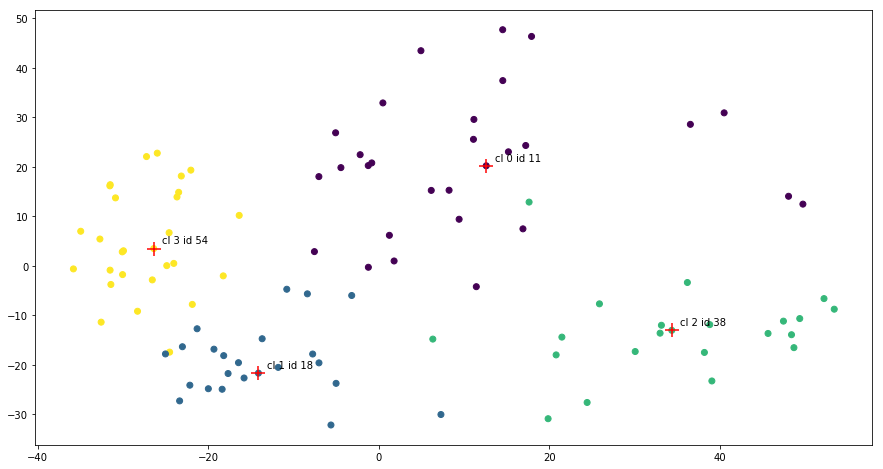

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

scatter = ax.scatter(x, y, c=clusters)
for k in group_dict:
    i = x[group_dict[k]]
    j = y[group_dict[k]]
    ax.scatter(i,j, s=200, c='red',marker='+')
    text = 'cl {} id {}'.format(k, group_dict[k])
    ax.annotate(text, (i + 1, j + 1))

По графику можем видеть что получилось достаточно неплохое разбиение на кластеры, так что думаю на этом можно остановиться.

#### 5. Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров p,d,q,P,D,Q — так, как это делалось на прошлой неделе. Не используйте данные за последний имеющийся месяц — май и июнь 2016!

In [13]:
region_df = df.iloc[:, [11, 18, 38, 54]]
region_df.head()

,1172,1179,1272,1332
2016-01-01 00:00:00,2.303934,0.975628,5.472612,1.201498
2016-01-01 01:00:00,6.826847,0.068775,10.780294,1.849727
2016-01-01 02:00:00,5.387738,-0.371482,11.664908,1.047411
2016-01-01 03:00:00,4.770977,-0.409110,5.598985,0.117574
2016-01-01 04:00:00,0.659238,-0.420399,2.313277,-0.780382


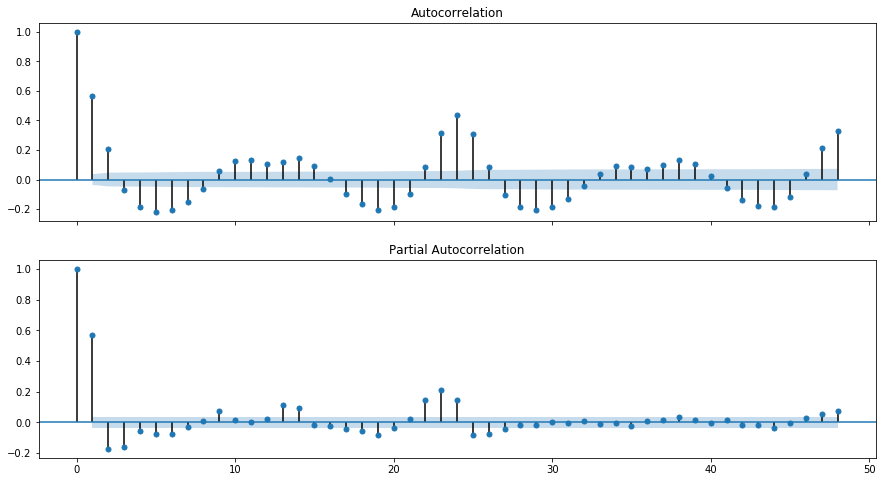

In [14]:
_, ax = plt.subplots(2, 1, sharex=True)
sm.graphics.tsa.plot_acf(region_df['1172'].values.squeeze(), lags=48, ax=ax[0])
sm.graphics.tsa.plot_pacf(region_df['1172'].values.squeeze(), lags=48, ax=ax[1])
plt.show()

In [15]:
p = range(2)
q = range(2)
P = range(2)
Q = range(2)

d, D = 1, 1

parameters = list(product(p, q, P, Q))
len(parameters)

16

In [16]:
train_dict = {0: '1172', 1: '1179', 2: '1272', 3: '1332'}
params_dict = {}
best_model_dict = {}

In [17]:
%%time
for c in tqdm(np.unique(clusters)):
    best_aic = float("inf")

    for param in parameters:
        try:
            model=sm.tsa.statespace.SARIMAX(region_df[train_dict[c]], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
        except LinAlgError:
            continue
        except ValueError:
            continue

        aic = model.aic
        if aic < best_aic:
            best_aic = aic
            params_dict[c] = param

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [31:02<00:00, 469.72s/it]


Wall time: 31min 2s


In [18]:
params_dict

{0: (1, 1, 1, 1), 1: (1, 1, 1, 1), 2: (1, 1, 1, 1), 3: (0, 1, 1, 1)}

#### 6. Для каждой из R географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по следующему функционалу:

$$Q_{june} = {1 \over R * 715 * 6} +\sum_{r=1}^{R} \sum_{2016.04.30\ 23:00}^{2016.05.31\ 17:00}\sum_{i=1}^{6} |\hat{y}_{T|T+i} - y^r_{T+i}|$$

In [20]:
hours_in_day = 24

sin_day = np.sin(np.array(range(1, hours_in_day + 1)) * 2 * np.pi / (hours_in_day))
sin_day = np.tile(sin_day, int(train_df.shape[0] / len(sin_day) + 1))

hours_in_week = 7 * 24
sin_week = np.sin(np.array(range(1, hours_in_week + 1)) * 2 * np.pi / (hours_in_week))
sin_week = np.tile(sin_week, int(train_df.shape[0] / len(sin_week) + 2))

days = {'sin_day_%d' % i: sin_day[i: train_df.shape[0] + i] for i in range(hours_in_day)}
weeks = {'sin_week_%d' % i: sin_week[i: train_df.shape[0] + i] for i in range(hours_in_week)}

sin_df = pd.DataFrame({**days, **weeks})

In [48]:
test_05_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_05.csv'), index_col=0)

In [191]:
may_start_period = datetime(2016, 4, 30, 23, 0, 0)
may_end_period = datetime(2016, 5, 31, 23, 0, 0)
offset = pd.DateOffset(hours=5)

X = sin_df.values

In [192]:
%%time

linea_pred_df = pd.DataFrame()
sarimax_pred_df = pd.DataFrame()

for c in tqdm(train_df.columns):
    
    p, q, P, Q = params_dict[clusters[train_df.columns.values.tolist().index(c)]]
    model = sm.tsa.statespace.SARIMAX(df[c], order=(p, d, q), seasonal_order=(P, D, Q, 24),
                                     enforce_invertibility=False, enforce_stationarity=False).fit(disp=-1)
        
    lr = LinearRegression().fit(X, df[c].values - model.fittedvalues)
    
    linea_pred_df[c] = lr.predict(X[:745])
    sarimax_pred_df[c] = model.predict(start=may_start_period, end=may_end_period).values

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [1:05:57<00:00, 34.72s/it]


Wall time: 1h 5min 57s


In [193]:
linea_pred_df.to_csv('tmp/may_linea_pred.csv')
sarimax_pred_df.to_csv('tmp/may_sarimax_pred.csv')

In [194]:
tmp_train_df = pd.read_csv('train_2.csv', index_col=0, parse_dates=[0])
tmp_df = ((tmp_train_df - tmp_train_df.mean()) / tmp_train_df.std()).fillna(0)

In [195]:
hours_in_day = 24

sin_day = np.sin(np.array(range(1, hours_in_day + 1)) * 2 * np.pi / (hours_in_day))
sin_day = np.tile(sin_day, int(tmp_train_df.shape[0] / len(sin_day) + 1))

hours_in_week = 7 * 24
sin_week = np.sin(np.array(range(1, hours_in_week + 1)) * 2 * np.pi / (hours_in_week))
sin_week = np.tile(sin_week, int(tmp_train_df.shape[0] / len(sin_week) + 2))

days = {'sin_day_%d' % i: sin_day[i: tmp_train_df.shape[0] + i] for i in range(hours_in_day)}
weeks = {'sin_week_%d' % i: sin_week[i: tmp_train_df.shape[0] + i] for i in range(hours_in_week)}

tmp_sin_df = pd.DataFrame({**days, **weeks})

In [196]:
%%time

june_start_period = datetime(2016, 5, 31, 23, 0, 0)
june_end_period = datetime(2016, 6, 30, 23, 0, 0)

X = tmp_sin_df.values

linea_pred_df = pd.DataFrame()
sarimax_pred_df = pd.DataFrame()

for c in tqdm(tmp_train_df.columns):
    
    p, q, P, Q = params_dict[clusters[tmp_train_df.columns.values.tolist().index(c)]]
    model = sm.tsa.statespace.SARIMAX(tmp_df[c], order=(p, d, q), seasonal_order=(P, D, Q, 24),
                                     enforce_invertibility=False, enforce_stationarity=False).fit(disp=-1)
        
    lr = LinearRegression().fit(X, tmp_df[c].values - model.fittedvalues)
    
    linea_pred_df[c] = lr.predict(X[:721])
    sarimax_pred_df[c] = model.predict(start=june_start_period, end=june_end_period).values

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [1:27:58<00:00, 42.89s/it]


Wall time: 1h 27min 58s


In [197]:
linea_pred_df.to_csv('tmp/june_linea_pred.csv')
sarimax_pred_df.to_csv('tmp/june_sarimax_pred.csv')

In [238]:
linea_pred_df = pd.read_csv('tmp/may_linea_pred.csv', index_col=0).loc[1:]
sarimax_pred_df = pd.read_csv('tmp/may_sarimax_pred.csv', index_col=0).loc[1:]

In [243]:
prediction_df = (sarimax_pred_df + linea_pred_df) * train_df.std() + train_df.mean()

In [321]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [246]:
error = 0
for c in tqdm(prediction_df.columns):
    error += sum(sum(abs(rolling_window(prediction_df[c], 6) - rolling_window(test_05_df[c], 6)))) / (6 * 739 * prediction_df.shape[1])

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 930.78it/s]


In [247]:
error

121.80709183566249

#### 7. Для каждой из R географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

In [399]:
start_period = june_start_period - pd.DateOffset(hours=5)
dates = [start_period + pd.DateOffset(hours=i) for i in range(721)]

In [394]:
linea_pred_df = pd.read_csv('tmp/june_linea_pred.csv', index_col=0).iloc[:-7]
sarimax_pred_df = pd.read_csv('tmp/june_sarimax_pred.csv', index_col=0).iloc[:-7]

In [395]:
prediction_df = (sarimax_pred_df + linea_pred_df) * train_df.std() + train_df.mean()

In [401]:
index = []
values = []

In [402]:
for c in tqdm(prediction_df.columns):
    t = rolling_window(prediction_df[c], 6)
    for idx, x in enumerate(t):
        for off, i in enumerate(x):
            tm = dates[idx + off]
            index.append('{}_2016-{:02}-{:02}_{}_{}'.format(c, tm.month, tm.day, tm.hour, 6 - off))
            values.append(int(i))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 74.09it/s]


#### 8. Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

In [403]:
result_df = pd.DataFrame(values, index=index)
result_df.columns = ['y']
result_df.index.name = 'id'
result_df.to_csv('result.csv')